In [53]:
# installer les packages nécessaires
# ! pip install psola librosa

# Méthode naive avec Librosa

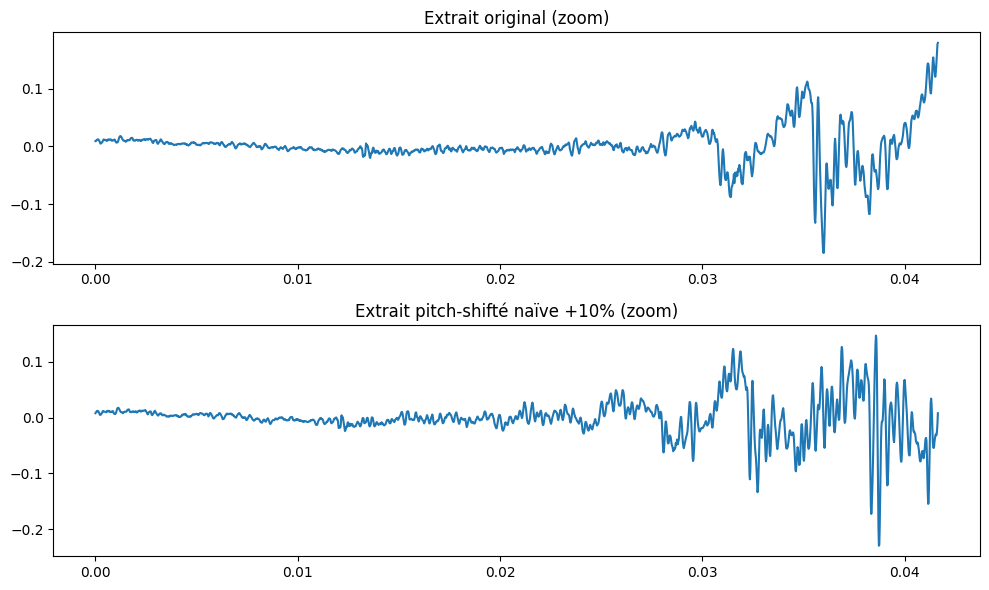

In [54]:
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# 1) Charger un EXTRAIT du son (par ex. 1 seconde)
y_full, sr = librosa.load("effacer.wav", sr=None)
duration_extract = 1.0  # 1 seconde
y = y_full[:int(sr*duration_extract)]

# 2) Calcul du pitch shift en demi-tons (+10%)
pitch_factor = 1.1
n_semitones = 12 * np.log2(pitch_factor)

# 3) Appliquer la méthode naïve (librosa)
y_shifted_naive = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_semitones)

# 4) Sauvegarder
sf.write("effacer_naive_extract.wav", y_shifted_naive, sr)

# 5) Plot
N = 2000  # zoom sur environ 2000 échantillons
t = np.arange(N) / sr

plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(t, y[:N])
plt.title("Extrait original (zoom)")

plt.subplot(2,1,2)
plt.plot(t, y_shifted_naive[:N])
plt.title("Extrait pitch-shifté naïve +10% (zoom)")

plt.tight_layout()
plt.show()


Sur ce zoom temporel (0 à 0,05 s environ), on peut faire plusieurs observations :

- Même amplitude globale :


L’enveloppe générale reste du même ordre de grandeur (le signal n’est pas beaucoup plus faible ou plus fort). Il n’y a pas eu de normalisation ou de compression majeure.


- Oscillations plus rapides sur la courbe pitch‐shiftée :


À partir d’environ 0,02 s, on remarque que le signal “accélère” un peu ses fluctuations et présente un plus grand nombre de variations sur une même fenêtre de temps.
Cela traduit un pitch plus élevé (plus de cycles par seconde).


- Conservation globale de la forme :


Le signal a gardé ses grandes caractéristiques temporelles (on reconnaît la même “structure”), mais on comprend l'effet, sur la version pitch‐shiftée, de l'augmentation de la fréquence fondamentale d’environ 10 %.


En résumé, le pitch shift se constate par le fait que, sur la même durée, la version traitée présente davantage d’oscillations (un cycle vocal plus fréquent). Visuellement, cela se traduit par des “pics” et “creux” plus resserrés, tout en conservant un niveau d’amplitude global similaire.

In [55]:
def calculate_f0(y, sr):
    """Calculer la fréquence fondamentale moyenne (F0)."""
    f0, voiced_flag, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0 = f0[~np.isnan(f0)]  # Supprimer les NaN
    return f0.mean()

In [56]:
# Calcul de F0 avant pitch shift
f0_original = calculate_f0(y, sr)
print(f"F0 original : {f0_original:.2f} Hz")

output_file = f"effacer_naive_extract.wav"
y_shifted, _ = librosa.load(output_file, sr=sr)
f0_shifted = calculate_f0(y_shifted, sr)
ratio = f0_shifted / f0_original
print(f"F0 après pitch shift (Naive) : {f0_shifted:.2f} Hz (ratio : {ratio:.2f})")

F0 original : 119.95 Hz
F0 après pitch shift (Naive) : 130.55 Hz (ratio : 1.09)


# PSOLA avec des marques à la main

In [57]:
import numpy as np
import soundfile as sf

def load_marks_txt(txt_file):
    """
    Lit un .txt : 
      position voise
      position voise
      ...
    Retourne (marques, voise) en numpy array
    """
    data = np.loadtxt(txt_file)
    M = data[:,0].astype(int)
    V = data[:,1].astype(int)
    return M, V

def psola_simple(signal, sr, marques, voise, pitch_factor=1.0, tfen=200):
    """
    Code PSOLA très simplifié :
      - voise=0 => fenêtre fixe (2*tfen)
      - voise=1 => fenêtre asservie via distances (2*(mk - prev), 2*(next - mk)) 
                   + décalage (dec) pour shift
    """
    out_len = len(signal) * 2
    sig_out = np.zeros(out_len, dtype=float)
    x1 = np.concatenate((signal, np.zeros(tfen)))  # marge
    dec = 0  # décalage accumulé
    # Pas de calcul de SNR ici, juste la resynthèse

    for i in range(len(marques)):
        mk = marques[i]
        # vérifier qu'on ne sort pas du signal
        if mk < tfen or mk >= (len(x1) - tfen):
            continue

        if voise[i] == 0:
            # Non voisée => fenêtre fixe
            start = mk - (tfen//2)
            end   = mk + (tfen//2)
            seg = x1[start:end]
            w = np.hanning(len(seg))  # fenêtrage Hanning
            seg_win = seg * w
            
            out_start = start + dec
            out_end   = out_start + len(seg_win)
            if out_start < 0 or out_end > out_len:
                continue
            sig_out[out_start:out_end] += seg_win

        else:
            # Voisé => on asservit la fenêtre à la distance
            # aux marques précédente et suivante
            if i == 0 or i == len(marques)-1:
                continue
            ll1 = 2*(mk - marques[i-1]) 
            ll2 = 2*(marques[i+1] - mk)
            if ll1<2 or ll2<2:
                continue
            
            start = mk - ll1//2
            end   = mk + ll2//2
            seg = x1[start:end]
            w = np.hanning(len(seg))
            seg_win = seg * w

            # Décalage pour le pitch
            local_per = (ll1//2 + ll2//2)
            shift = int(round(local_per * -(pitch_factor - 1.0)))
            dec += shift

            out_start = start + dec
            out_end   = out_start + len(seg_win)
            if out_start<0 or out_end>out_len:
                continue
            sig_out[out_start:out_end] += seg_win

    # Tronquer le résultat
    # (pour conserver la même durée, on ne prend que la taille d'origine)
    return sig_out[:len(signal)]

##############################
#  Main code
##############################
# 1) Lecture audio
audio_file = "effacer.wav"
y, sr = sf.read(audio_file)
y = y.astype(float)
print(f"Audio '{audio_file}' chargé : {len(y)} échantillons, sr={sr}")

# 2) Lecture marques
marks_file = "effacer.txt"
marques, voise = load_marks_txt(marks_file)
print(f"{len(marques)} marques chargées depuis '{marks_file}'")

# 3) Paramètres
pitch_factor = 1.1  # +10%
tfen = 200          # ~200 échantillons => ~4ms @ 48kHz (à ajuster)

# 4) Appliquer PSOLA
y_psola = psola_simple(y, sr, marques, voise, pitch_factor=pitch_factor, tfen=tfen)

# 5) Sauvegarder
sf.write("effacer_psola_pitch10.wav", y_psola, sr)
print("Fichier sauvegardé : effacer_psola_pitch10.wav")


Audio 'effacer.wav' chargé : 43389 échantillons, sr=48000
16 marques chargées depuis 'effacer.txt'
Fichier sauvegardé : effacer_psola_pitch10.wav


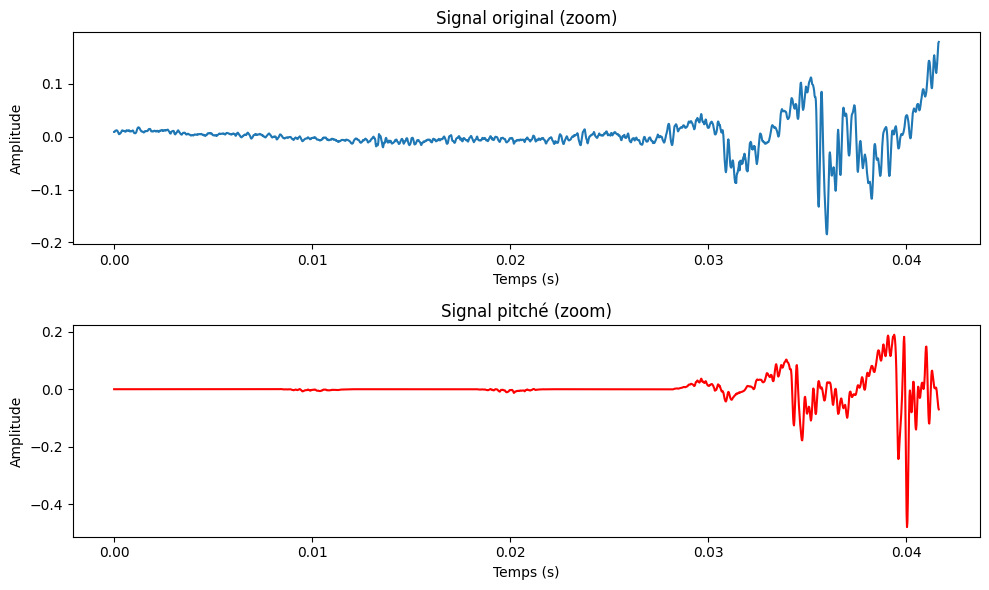

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# sr : une fréquence d'échantillonnage

N = 2000  # nombre d'échantillons à tracer (zoom)
t = np.arange(N) / sr

plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(t, y[:N], label="Original")
plt.title("Signal original (zoom)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(t, y_psola[:N], label="Pitché", color='r')
plt.title("Signal pitché (zoom)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# PSOLA avec des méthodes de génération de marques

In [59]:
import numpy as np
import librosa

def frame_energy(signal_frame):
    """Calculer l'énergie d'une trame."""
    return np.sum(signal_frame ** 2)

def zero_crossing_rate(signal_frame):
    """Calculer le taux de passage par zéro (ZCR)."""
    crossings = np.where(np.diff(np.sign(signal_frame)))[0]
    return len(crossings) / len(signal_frame)

def is_voiced_frame(signal_frame, threshold=0.3):
    """Détecter si une trame est voisée en utilisant l'auto-corrélation."""
    signal_frame = signal_frame - np.mean(signal_frame)
    signal_frame = signal_frame / np.max(np.abs(signal_frame))
    
    autocorr = np.correlate(signal_frame, signal_frame, mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Garder la partie positive
    autocorr_norm = autocorr / autocorr[0]
    
    second_peak = np.max(autocorr_norm[1:])
    return second_peak > threshold

def generate_marks(signal, sr, frame_size=400, hop_size=160, method="energy", threshold=0.3):
    """Générer les marques et voisement."""
    num_frames = (len(signal) - frame_size) // hop_size
    marks = []
    voiced = []
    
    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        frame = signal[start:end]
        
        if method == "energy":
            energy = frame_energy(frame)
            is_voiced = energy > threshold
        elif method == "zcr":
            zcr = zero_crossing_rate(frame)
            is_voiced = zcr < threshold
        elif method == "autocorrelation":
            is_voiced = is_voiced_frame(frame, threshold=threshold)
        else:
            raise ValueError(f"Méthode inconnue : {method}")
        
        marks.append(start + frame_size // 2)
        voiced.append(int(is_voiced))
    
    return np.array(marks), np.array(voiced)

# Charger un fichier audio
audio_file = "effacer.wav"
y, sr = librosa.load(audio_file, sr=None)

# Générer les marques pour chaque méthode
methods = ["energy", "zcr", "autocorrelation"]
for method in methods:
    marks, voiced = generate_marks(y, sr, method=method, threshold=0.3)
    np.savetxt(f"effacer_{method}.txt", np.column_stack((marks, voiced)), fmt="%d")
    print(f"Marques générées avec la méthode '{method}' sauvegardées dans 'effacer_{method}.txt'")


Marques générées avec la méthode 'energy' sauvegardées dans 'effacer_energy.txt'
Marques générées avec la méthode 'zcr' sauvegardées dans 'effacer_zcr.txt'
Marques générées avec la méthode 'autocorrelation' sauvegardées dans 'effacer_autocorrelation.txt'


In [60]:
methods = ["energy", "zcr", "autocorrelation"]

for method in methods:
    # Charger les marques générées par la méthode
    marks_file = f"effacer_{method}.txt"
    marques, voise = load_marks_txt(marks_file)
    print(f"{len(marques)} marques chargées depuis '{marks_file}'")

    # Appliquer PSOLA
    y_psola = psola_simple(y, sr, marques, voise, pitch_factor=pitch_factor, tfen=tfen)

    # Sauvegarder le résultat
    output_file = f"effacer_psola_pitch10_{method}.wav"
    sf.write(output_file, y_psola, sr)
    print(f"Fichier sauvegardé : {output_file}")

268 marques chargées depuis 'effacer_energy.txt'
Fichier sauvegardé : effacer_psola_pitch10_energy.wav
268 marques chargées depuis 'effacer_zcr.txt'
Fichier sauvegardé : effacer_psola_pitch10_zcr.wav
268 marques chargées depuis 'effacer_autocorrelation.txt'
Fichier sauvegardé : effacer_psola_pitch10_autocorrelation.wav


In [61]:
def calculate_f0(y, sr):
    """Calculer la fréquence fondamentale moyenne (F0)."""
    f0, voiced_flag, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0 = f0[~np.isnan(f0)]  # Supprimer les NaN
    return f0.mean()

In [62]:
# Calcul de F0 avant pitch shift
f0_original = calculate_f0(y, sr)
print(f"F0 original : {f0_original:.2f} Hz")

# Calcul de F0 après pitch shift pour chaque méthode
for method in methods:
    output_file = f"effacer_psola_pitch10_{method}.wav"
    y_shifted, _ = librosa.load(output_file, sr=sr)
    f0_shifted = calculate_f0(y_shifted, sr)
    ratio = f0_shifted / f0_original
    print(f"F0 après pitch shift ({method}) : {f0_shifted:.2f} Hz (ratio : {ratio:.2f})")


F0 original : 119.95 Hz
F0 après pitch shift (energy) : 73.00 Hz (ratio : 0.61)
F0 après pitch shift (zcr) : 150.49 Hz (ratio : 1.25)
F0 après pitch shift (autocorrelation) : 150.52 Hz (ratio : 1.25)


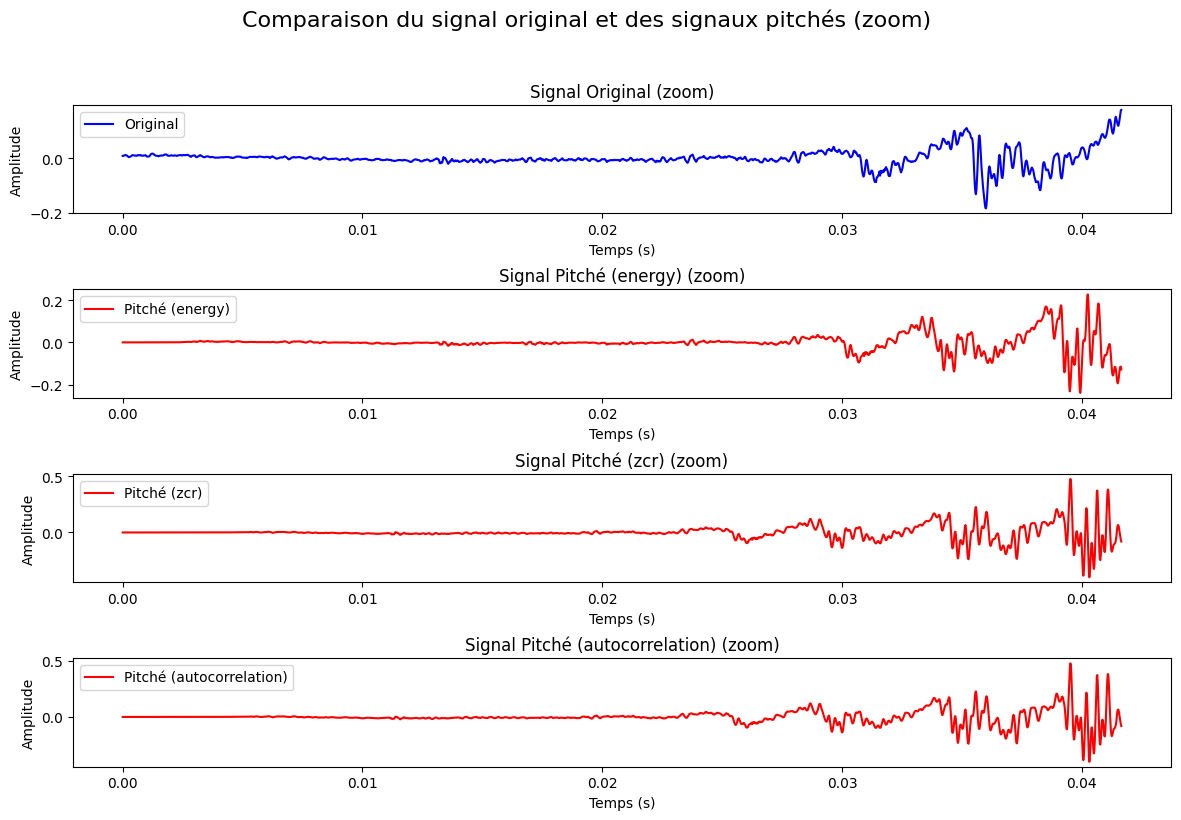

In [63]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Chargement du signal original
y_orig, sr = librosa.load("effacer.wav", sr=None)

# Méthodes utilisées
methods = ["energy", "zcr", "autocorrelation"]

# Zoom sur les premiers N échantillons
N = 2000  # Nombre d'échantillons pour zoomer
t = np.arange(N) / sr  # Échelle de temps (en secondes)

# Création de la figure
plt.figure(figsize=(12, 8))

# Subplot pour le signal original
plt.subplot(len(methods) + 1, 1, 1)  
plt.plot(t, y_orig[:N], label="Original", color="b")
plt.title("Signal Original (zoom)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()

# Subplots pour les signaux pitchés
for i, method in enumerate(methods):
    # Chargement du fichier pitché correspondant à la méthode
    output_file = f"effacer_psola_pitch10_{method}.wav"
    y_shifted, _ = librosa.load(output_file, sr=sr)

    # Subplot pour la méthode actuelle
    plt.subplot(len(methods) + 1, 1, i + 2)  
    plt.plot(t, y_shifted[:N], label=f"Pitché ({method})", color="r")
    plt.title(f"Signal Pitché ({method}) (zoom)")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()

plt.tight_layout()
plt.suptitle("Comparaison du signal original et des signaux pitchés (zoom)", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


# Méthodes Semi automatiques avec PSOLA

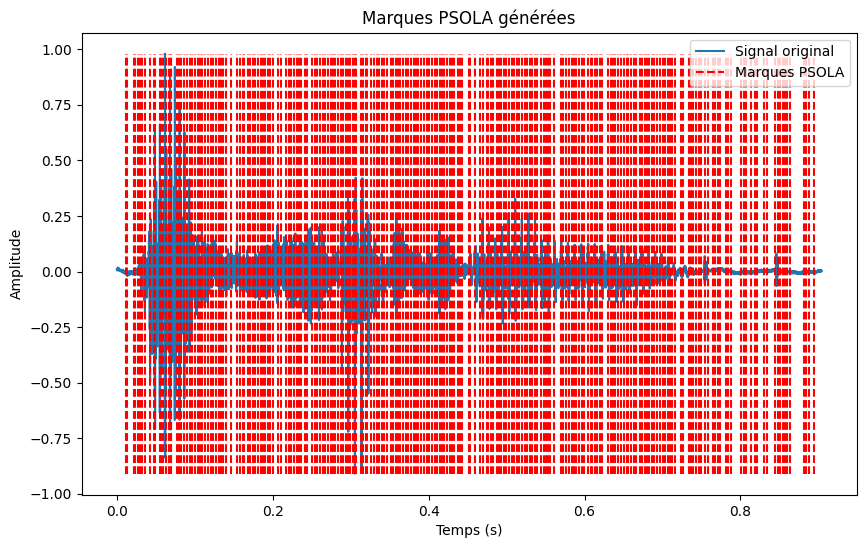

Marques PSOLA sauvegardées dans 'psola_marks.txt'


In [64]:
import numpy as np
from scipy.signal import butter, lfilter, find_peaks
import librosa
import matplotlib.pyplot as plt


# 1. Fonction pour charger et filtrer l'audio
def load_audio(filename):
    y, sr = librosa.load(filename, sr=None)
    return y, sr

def bandpass_filter(signal, fs, lowcut=50, highcut=300):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(5, [low, high], btype="band")
    return lfilter(b, a, signal)

# 2. Calcul des métriques
def energy(signal):
    """Calculer l'énergie d'un signal."""
    return np.sum(signal**2) / len(signal)

def zcr(signal):
    """Calculer le taux de passage par zéro."""
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

def autocorrelation(signal):
    """Calculer l'auto-corrélation du signal."""
    result = np.correlate(signal, signal, mode="full")
    return result[result.size // 2:]

# 3. Détection des parties voisées
def detect_voiced_parts(signal, fs, threshold_energy=0.01, threshold_zcr=0.1):
    """Détecter les parties voisées en utilisant l'énergie et le ZCR."""
    filtered_signal = bandpass_filter(signal, fs, lowcut=50, highcut=300)
    energy_signal = energy(filtered_signal)
    zcr_signal = zcr(filtered_signal)
    
    is_potentially_voiced = energy_signal > threshold_energy and zcr_signal < threshold_zcr
    return filtered_signal, is_potentially_voiced

# 4. Positionnement des marques PSOLA
def generate_psola_marks(signal, fs, frame_size=400, hop_size=160):
    """Générer les marques PSOLA semi-automatiquement."""
    num_frames = (len(signal) - frame_size) // hop_size
    psola_marks = []

    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        frame = signal[start:end]

        # Détecter si la trame est voisée
        filtered_frame, is_voiced = detect_voiced_parts(frame, fs)

        if is_voiced:
            # Auto-corrélation pour les trames voisées
            autocorr_signal = autocorrelation(filtered_frame)
            peaks, _ = find_peaks(autocorr_signal, height=0)
            if len(peaks) > 0:
                # Ajouter la première marque détectée
                psola_marks.append(start + peaks[0])

    return np.array(psola_marks)

# 5. Visualisation des marques PSOLA
def plot_psola_marks(signal, sr, marks):
    """Visualiser les marques PSOLA sur le signal."""
    t = np.arange(len(signal)) / sr
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal, label="Signal original")
    plt.vlines(marks / sr, ymin=np.min(signal), ymax=np.max(signal), color="red", label="Marques PSOLA", linestyle="--")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title("Marques PSOLA générées")
    plt.legend()
    plt.show()


# 6. Exécution du script
audio_file = "effacer.wav"  # Remplacez par votre fichier audio
y, sr = load_audio(audio_file)

# Générer les marques PSOLA
marks = generate_psola_marks(y, sr, frame_size=400, hop_size=160)

# Visualiser les marques
plot_psola_marks(y, sr, marks)

# Sauvegarder les marques dans un fichier texte
np.savetxt("psola_marks.txt", marks, fmt="%d")
print("Marques PSOLA sauvegardées dans 'psola_marks.txt'")
